In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

/home/rupeshr/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/rupeshr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rupeshr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rupeshr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
#splitting the train test ratio
def train_test_split(data, train_ratio):
    len_data = len(data)
    train_size = int(len_data * train_ratio)
    train, test = data[0:train_size], data[train_size:len_data]
    return train, test

#Scaling operations
def scale(scaler,train, test):
    train_scaled=scaler.fit_transform(train.values)
    test_scaled =scaler.fit_transform(test.values)
    return train_scaled, test_scaled

# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_features
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

#future forecast function
def future_forecast(df,scaler,X_test,n_steps, savemodel,freq,future_period):
    savemodel.save("model.h5")
    model = load_model('model.h5')
    x_input =X_test[-1]
    temp_input=list(x_input) 
    lst_output=[]
    for i in range(future_period):
        x_input=np.array(temp_input[i:])
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0])
        lst_output.append(yhat[0])
    lst_output = scaler.inverse_transform(lst_output)
    future_date = pd.date_range(df.index[-1], periods=future_period+1,freq=freq, closed='right')
    future_dataframe=pd.DataFrame(future_date, columns=['future_dates'])
    future_dataframe.set_index('future_dates', inplace=True)
    forecast=pd.DataFrame(lst_output, index=future_dataframe.index, columns=['forecast'])
    return forecast

def univariate_lstm(*,df, date_col, target_col, n_steps, scaling,ratio, future_period, freq,hidden_layer, activationtype, no_of_epochs, n_batch, earlystop):
    
    df=df[[date_col, target_col]]
    df[date_col]=pd.to_datetime(df[date_col])
    df=df.set_index(date_col)
    
    train, test =train_test_split(df, ratio)
    
    if scaling =='minmaxscaler': #-1 to 1
        scaler = MinMaxScaler()
        train_scaled, test_scaled = scale(scaler,train, test)
    elif scaling == 'standardscaler':
        scaler = StandardScaler() # 0 to 1
        train_scaled, test_scaled = scale(scaler,train, test)
    
    X_train, y_train = prepare_data(train_scaled, n_steps)
    
    X_test, y_test = prepare_data(test_scaled, n_steps)
    
    train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    
    if hidden_layer ==1: # taken upto 3 hidden layer with default neurons
        model.add(LSTM(50, activation=activationtype, input_shape=(n_steps, 1))) # input layer
    elif hidden_layer ==2:
        model.add(LSTM(128, activation=activationtype, return_sequences=True, input_shape=(n_steps, 1))) # input layer
        model.add(LSTM(50, activation=activationtype))
    elif hidden_layer ==3:
        model.add(LSTM(128, activation=activationtype, return_sequences=True, input_shape=(n_steps, 1))) # input layer
        model.add(LSTM(128, activation=activationtype,return_sequences=True))
        model.add(Dropout(0.3)) # to avoid overfitting
        model.add(LSTM(64,return_sequences=False))
        model.add(Dropout(0.3))
        
    model.add(Dense(1)) # output layer
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor ='loss', patience=earlystop) # earlystop method 
    
    model.fit(train_reshaped, y_train, epochs=no_of_epochs, batch_size=n_batch,verbose=1,callbacks=[es])
    
    print(model.summary())
    pred = model.predict(test_reshaped, verbose=0)  #test_scaled[:,:][n_steps:]
    prediction = scaler.inverse_transform(pred)
    y_test = scaler.inverse_transform(y_test)
    df_pred = pd.concat([pd.DataFrame(prediction, columns=['prediction'],index=test.index[n_steps:]), pd.DataFrame(y_test, columns=['test'],index=test.index[n_steps:])], axis=1)
    rmse = sqrt(mean_squared_error(y_test, prediction))
    print(rmse)
    forecast=future_forecast(df,scaler,X_test,n_steps, model,freq,future_period)
    return df,df_pred,rmse,forecast

In [3]:
df=pd.read_csv('/home/rupeshr/Desktop/TSA_Python/dataset/data_new/monthly-car-sales.csv')
date_col='Month'
target_col='Sales'
n_steps=3
scaling ='standardscaler' # minmaxscaler
ratio=0.80
activationtype='relu' # tanh ,sigmoid
hidden_layer=3 #1,2,3
n_batch=2
no_of_epochs=20
earlystop=2  
freq='MS'
future_period=12
df,df_pred,rmse, forecast=univariate_lstm(df=df,date_col=date_col, target_col=target_col, n_steps=n_steps,scaling=scaling, ratio=ratio,activationtype=activationtype, hidden_layer=hidden_layer,no_of_epochs=no_of_epochs, earlystop=earlystop, n_batch=n_batch, future_period=future_period,freq=freq)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
83/83 [==============================] - 12s 145ms/sample - loss: 0.9848
Epoch 2/20
83/83 [==============================] - 3s 32ms/sample - loss: 0.9661
Epoch 3/20
83/83 [==============================] - 3s 32ms/sample - loss: 0.9382
Epoch 4/20
83/83 [==============================] - 3s 31ms/sample - loss: 0.8780
Epoch 5/20
83/83 [==============================] - 3s 33ms/sample - loss: 0.7380
Epoch 6/20
83/83 [==============================] - 3s 31ms/sample - loss: 0.6425
Epoch 7/20
83/83 [==============================] - 3s 31ms/sample - loss: 0.5832
Epoch 8/20
83/83 [==============================] - 3s 32ms/sample - loss: 0.6027
Epoch 9/20
83/83 [==============================] - 3s 32ms/sample - loss: 0.5232
Epoch 10/20
83/83 [=============================

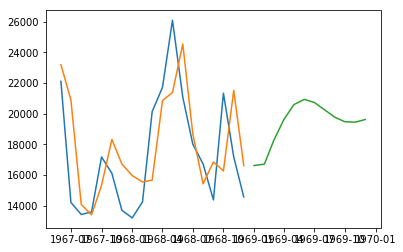

In [4]:
import matplotlib.pyplot as plt
plt.plot(df_pred['test'])
plt.plot(df_pred['prediction'])
plt.plot(forecast)
plt.show()